In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
from credentials import *

auth = tw.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

In [4]:
search_term = "#climate+change -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2018-11-01').items(1000)

all_tweets = [tweet.text for tweet in tweets]

all_tweets[:5]


["Greenpeace And Google 'Disappear' Skeptic Co-founder https://t.co/lQyFVwsISt via\n @john0sullivanp2\n\nPleased to see… https://t.co/85HxY3kakw",
 '#Climate #News: Scientists study fish to learn how to adapt to the impacts of climate change https://t.co/PjWvqcvJ4o',
 'Personal responsibility is not enough to fix #climate change https://t.co/N5Cp3aS6y3',
 '.@UNDPArmenia convenes people from all walks of life to discuss use of #tech for #climate solutions and driving cha… https://t.co/5osf3upD6s',
 'Flies and fungi: #Climate change could make #food less safe, experts warn https://t.co/XZ2w4jkikR #environment https://t.co/SikLsgNfsw']

In [5]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [6]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['Greenpeace And Google Disappear Skeptic Cofounder via john0sullivanp2Pleased to see',
 'Climate News Scientists study fish to learn how to adapt to the impacts of climate change',
 'Personal responsibility is not enough to fix climate change',
 'UNDPArmenia convenes people from all walks of life to discuss use of tech for climate solutions and driving cha',
 'Flies and fungi Climate change could make food less safe experts warn environment']

In [7]:
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[:2]

[['greenpeace',
  'and',
  'google',
  'disappear',
  'skeptic',
  'cofounder',
  'via',
  'john0sullivanp2pleased',
  'to',
  'see'],
 ['climate',
  'news',
  'scientists',
  'study',
  'fish',
  'to',
  'learn',
  'how',
  'to',
  'adapt',
  'to',
  'the',
  'impacts',
  'of',
  'climate',
  'change']]

In [8]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('climate', 858),
 ('the', 624),
 ('change', 606),
 ('to', 498),
 ('of', 307),
 ('is', 253),
 ('in', 243),
 ('and', 238),
 ('on', 237),
 ('a', 229),
 ('climatechange', 162),
 ('for', 154),
 ('we', 128),
 ('are', 117),
 ('that', 79)]

In [9]:
#Based on the counter, you can create a Pandas Dataframe for analysis and plotting that includes only the top 15 most common words.
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,climate,858
1,the,624
2,change,606
3,to,498
4,of,307


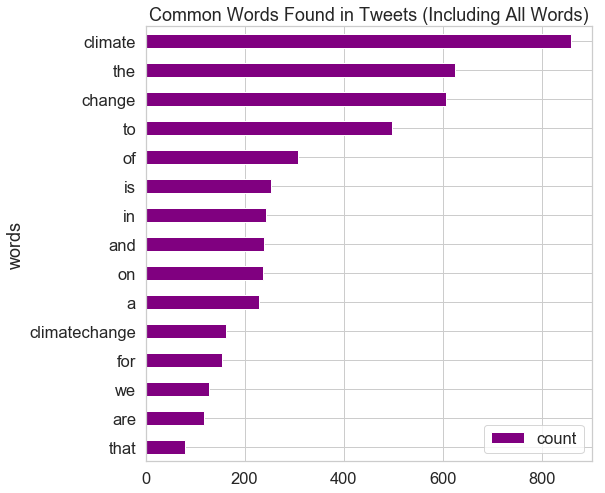

In [10]:
#Using this Pandas Dataframe, you can create a horizontal bar graph of the top 15 most common words in the tweets as shown below.
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

### Remove Stopwords With nltk

In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['it',
 'having',
 'from',
 'how',
 'been',
 "shan't",
 "you'll",
 'ours',
 'myself',
 'ourselves']

In [12]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['greenpeace',
 'google',
 'disappear',
 'skeptic',
 'cofounder',
 'via',
 'john0sullivanp2pleased',
 'see']

In [13]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('climate', 858),
 ('change', 606),
 ('climatechange', 162),
 ('students', 74),
 ('world', 74),
 ('future', 58),
 ('amp', 56),
 ('global', 54),
 ('action', 51),
 ('people', 50),
 ('us', 44),
 ('school', 39),
 ('new', 38),
 ('strike', 38),
 ('join', 36)]

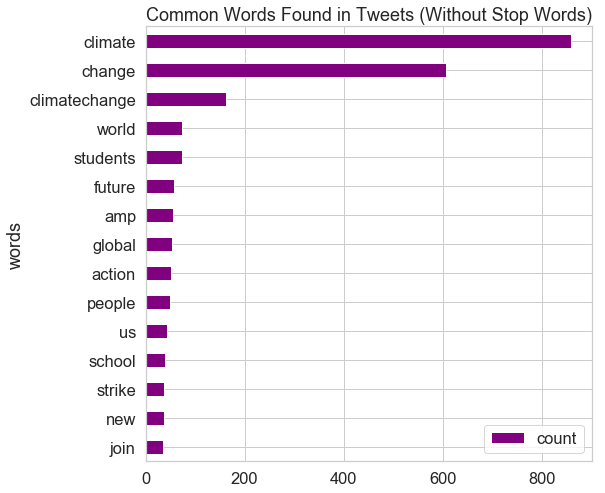

In [14]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

### Remove Collection Words
In additional to removing stopwords, it is common to also remove collection words. Collection words are the words that you used to query your data from Twitter.

In [15]:
collection_words = ['climatechange', 'climate', 'change']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

In [ ]:
# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))

# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

In [ ]:
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])
clean_tweets_ncw.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()

This plot displays the frequency of all words in the tweets on climate change, after URLs, stop words, and collection words have been removed.